In [1]:
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython

import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import scipy

from music import *

In [2]:
fs, data = wavfile.read('res/arctic_a0010.wav')
data_variance = np.var(data)
IPython.display.Audio(data, rate=fs)

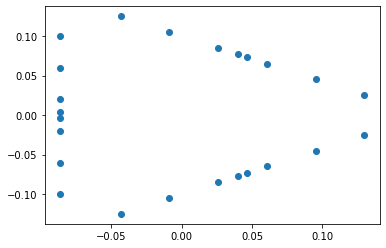

In [3]:
import json

with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

plt.scatter(microphone_2D_locations[:, 0], microphone_2D_locations[:, 1])
plt.show()

In [4]:
c = 343.    # speed of sound
# fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]
radius=4e-1
mic_distance = 4e-1
start = 4
n_mics = 6

snr_db = 2
distance = 3.  # meters idk wtf is happening
sigma2 = 0
wavelength = 1

(<Figure size 432x288 with 1 Axes>, <Axes: >)

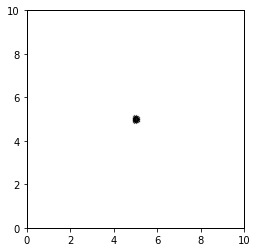

In [5]:
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# Adding the microphones

mics_coords = (microphone_2D_locations + room_dim / 2).T
aroom.add_microphone_array(pra.MicrophoneArray(mics_coords, aroom.fs))

aroom.plot()

(<Figure size 432x288 with 1 Axes>, <Axes: >)

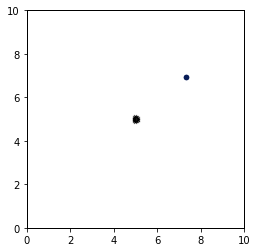

In [6]:
# Add sources of 1 second duration
azimuth = np.array([40]) / 180. * np.pi

rng = np.random.RandomState(23)
duration_samples = 10000

for ang in azimuth:
    random_phase = np.random.uniform(0, 2 * np.pi)
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    aroom.add_source(source_location, signal=data)
    
# Run the simulation
aroom.simulate()
aroom.plot()

In [7]:
IPython.display.Audio(aroom.mic_array.signals[0], rate=fs)

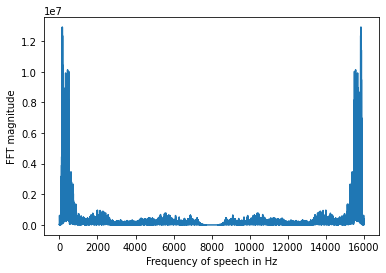

In [8]:
fft = np.fft.fft(data)
frequencies = np.linspace(0, fs, len(fft))

selected_ids = np.argwhere(frequencies < 100000)
selected_freq = frequencies[selected_ids]
selected_fft = fft[selected_ids]

plt.plot(selected_freq, abs(selected_fft))
plt.xlabel("Frequency of speech in Hz")
plt.ylabel("FFT magnitude")
plt.show()

Samples shape: (24, 57268)
Covariance shape: (24, 24)


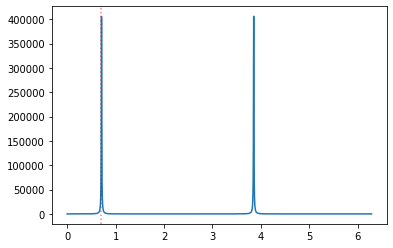

In [9]:
n_sources = len(azimuth)

signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors = music(aroom.mic_array.signals, -2)
spectrum = general_spectrum_function(noise_eigenvectors, mics_coords.T, 150)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

In [48]:
n_sources = len(azimuth)
seg_duration = 0.5
freq_range=[90, 150]

nperseg = seg_duration * fs
spectrums = music_with_frequency(aroom.mic_array.signals, -10, fs, microphone_2D_locations.T, segment_duration=seg_duration, freq_range=freq_range)

(4001, 24)
Covariance matrices shape: (4001, 24, 24)
[22.5 37.5]


In [49]:
fs

16000

In [53]:
X = np.linspace(0, 2 * np.pi, 1000)
Y = np.array([np.array([spectrums[i](x) for x in X]) for i in range(len(spectrums))])

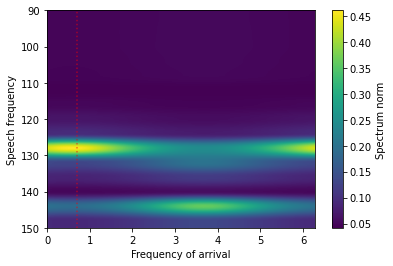

In [54]:
c = plt.imshow(Y, aspect='auto', extent=[X[0], X[-1], freq_range[1], freq_range[0]])
plt.colorbar(c, label="Spectrum norm") 
plt.ylabel("Speech frequency")
plt.xlabel("Frequency of arrival")

for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)

plt.show()

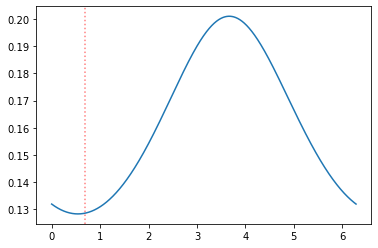

In [55]:
plt.plot(X, Y[10])
for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()